## Imports

In [150]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import sys, os

# useful additional packages 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import numpy.random as npr
from numpy import pi
from scipy import linalg as la
from scipy import optimize
from functools import partial

# importing the QISKit
from qiskit import QuantumProgram
import Qconfig

# import basic plot tools
from qiskit.tools.visualization import plot_histogram


# import optimization tools
from qiskit.tools.apps.optimization import SPSA_optimization, SPSA_calibration
from qiskit.tools.apps.optimization import make_Hamiltonian, trial_circuit_ry
from qiskit.tools.apps.optimization import eval_hamiltonian, group_paulis

# Ignore warnings due to chopping of small imaginary part of the energy 
import warnings
warnings.filterwarnings('ignore')

from qiskit.tools.qi.pauli import Pauli

## Global Constants

In [151]:
#Backend to run on
device='local_qasm_simulator'

## Helper Functions

In [152]:
def xy_to_idx(size, x, y):
    return (x%size[0])*size[1] + (y%size[1])

def spin_wave_circuit(size, theta):
    #Creates a circuit which initializes a 2D spin wave, of size 'size' and rate of change 'theta'
    N = size[0]*size[1] #Number of spins
    q = QuantumRegister("q", N)
    c = ClassicalRegister("c", N)
    circuit = QuantumCircuit(q, c)
    for i in range(size[0]):
        for j in range(size[1]):
            phase = theta[0] + theta[1]*(i+j)
            idx = xy_to_idx(size, i, j)
            circuit.ry(phase, q[idx])
            if len(theta) > 2: #Only do phi rotations if the initial guess includes them
                phi = theta[2] + theta[3]*(i+j)
                circuit.rz(phi, q[idx])
    return circuit

def ising_hamiltonian(size, h, J, D):
    N = size[0]*size[1] #Number of spins
    pauli_list = []
    zeros = np.zeros(N)
    
    #External field
    for i in range(size[0]):
        for j in range(size[1]):
            idx = xy_to_idx(size, i, j)
            mask = np.copy(zeros)
            mask[idx] = 1
            
            #Adding in X terms
            pauli = Pauli(zeros, mask)
            pauli_list.append([-h[0], pauli])
            
            #Adding in Y terms
            pauli = Pauli(mask, mask)
            pauli_list.append([-h[1], pauli])
            
            #Adding in Z terms
            pauli = Pauli(mask, zeros)
            pauli_list.append([-h[2], pauli])
            
            
    for i in range(size[0]):
        for j in range(size[1]):
            #X-neighbors
            idx1 = xy_to_idx(size, i, j)
            idx2 = xy_to_idx(size, i+1, j)
            mask = np.copy(zeros)
            mask[idx1] = 1
            mask[idx2] = 1
            
            #Adding in X terms
            pauli = Pauli(zeros, mask)
            pauli_list.append([-J[0], pauli])
            
            #Adding in Y terms
            pauli = Pauli(mask, mask)
            pauli_list.append([-J[1], pauli])
            
            #Adding in Z terms
            pauli = Pauli(mask, zeros)
            pauli_list.append([-J[2], pauli])
            
            '''
            #Y-neighbors
            idx2 = xy_to_idx(size, i, j+1)
            mask = np.copy(zeros)
            mask[idx1] = 1
            mask[idx2] = 1
            
            #Adding in X terms
            pauli = Pauli(zeros, mask)
            pauli_list.append([-J[0], pauli])
            
            #Adding in Y terms
            pauli = Pauli(mask, mask)
            pauli_list.append([-J[1], pauli])
            
            #Adding in Z terms
            pauli = Pauli(mask, zeros)
            pauli_list.append([-J[2], pauli])
            
            #D+ neighbors
            idx2 = xy_to_idx(size, i+1, j+1)
            mask = np.copy(zeros)
            mask[idx1] = 1
            mask[idx2] = 1
            
            #Adding in X terms
            pauli = Pauli(zeros, mask)
            pauli_list.append([-D[0], pauli])
            
            #Adding in Y terms
            pauli = Pauli(mask, mask)
            pauli_list.append([-D[1], pauli])
            
            #Adding in Z terms
            pauli = Pauli(mask, zeros)
            pauli_list.append([-D[2], pauli])
            
            #D+ neighbors
            idx2 = xy_to_idx(size, i+1, j-1)
            mask = np.copy(zeros)
            mask[idx1] = 1
            mask[idx2] = 1
            
            #Adding in X terms
            pauli = Pauli(zeros, mask)
            pauli_list.append([-D[0], pauli])
            
            #Adding in Y terms
            pauli = Pauli(mask, mask)
            pauli_list.append([-D[1], pauli])
            
            #Adding in Z terms
            pauli = Pauli(mask, zeros)
            pauli_list.append([-D[2], pauli])
            '''
    
    #Filtering out zero terms
    pauli_list = [pauli for pauli in pauli_list if pauli[0] != 0]
    #for pauli in pauli_list:
    #    print(pauli[0], pauli[1].to_label())
    return pauli_list

#Creating a cost function
def cost_function(Q_program, size, H, theta):
    shots = 100 #TODO: Should this ever change?
    return eval_hamiltonian(Q_program, H, spin_wave_circuit(size, theta), shots, device).real

def SPSA_optimize(size, H, theta_i):
    #SPSA variables
    initial_c = 0.01
    target_update = 2*np.pi*0.1
    save_step = 1000
    max_trials = max_steps
    
    cost = partial(cost_function, Q_program, size, H)
    SPSA_params = SPSA_calibration(cost, theta_i, initial_c, target_update, 5)
    output = SPSA_optimization(cost, theta_i, SPSA_params, max_trials, save_step, 1)
    return output

def NM_optimize(size, H, theta_i, max_steps):
    options = {'disp' : True, 'maxiter': max_steps}
    cost = partial(cost_function, Q_program, size, H)
    res = optimize.minimize(cost, theta_i, method="Nelder-Mead", options=options)
    output = [res.fun, res.x]
    return output

def callbackF(Xi):
    global Nfeval
    print('{0:4d}   {1: 3.6f}   {2: 3.6f}   {3: 3.6f}   {4: 3.6f}'.format(Nfeval, Xi[0], Xi[1], Xi[2], rosen(Xi)))
    Nfeval += 1

def optim(size, H, theta_i, max_steps):
    return NM_optimize(size, H, theta_i, max_steps)

## Testing
Let's start with the simplest case - J=0. Without another scale, we can set h = + 1.

Text(0,0.5,'Energy')

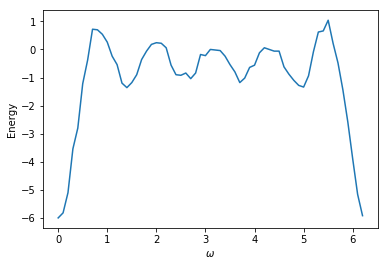

In [153]:
###### Creating a program
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

size = [6,1]
h = [0,0,1]
J = [0,0,0]
D = [0,0,0]
H = ising_hamiltonian(size, h, J, D)
H = group_paulis(H)

omegas = np.arange(0,2*pi,0.1)
thetas = [(0, omega) for omega in omegas]
energy = [cost_function(Q_program, size, H, theta) for theta in thetas]


plt.plot(omegas, energy, label='Energy')
plt.xlabel('$\omega$')
plt.ylabel('Energy')

Similarly, can set J=1, h=0.

Text(0,0.5,'Energy')

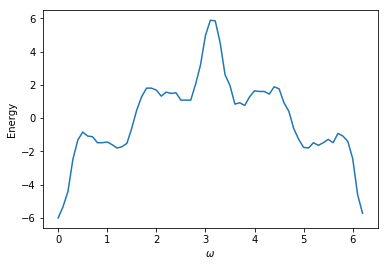

In [154]:
h = [0,0,0]
J = [1,0,0]
D = [0,0,0]
H = ising_hamiltonian(size, h, J, D)
H = group_paulis(H)

omegas = np.arange(0,2*pi,0.1)
thetas = [(pi/2, omega) for omega in omegas]
energy = [cost_function(Q_program, size, H, theta) for theta in thetas]


plt.plot(omegas, energy, label='Energy')
plt.xlabel('$\omega$')
plt.ylabel('Energy')

# GSE and Order Parameters
## FM Coupling

In [155]:
#Creating a program
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

size = [4,1]
J = [1,0,0]
D = [0,0,0]
energy = []
theta = []
exact = []
gs = np.arange(-20,25,5)
#Number of optimization steps
max_steps = 100

#Initial guess calculation
#seeds = 10 #How many initial seeds to take
#E_g = float('Inf')
theta_g = (pi,0)

#for seed in range(seeds):
#    theta_i = npr.rand(2)*pi #We're only doing x/z terms, so no need for phi rotations
#    results = optim(size, H, theta_i)
#    if results[0] < E_g:
#        E_g = results[0]
#        theta_g = np.mod(results[1], 2*pi)
    

for g in gs:
    h = [0,0,g]
    H = ising_hamiltonian(size, h, J, D)
    exact.append(np.amin(la.eig(make_Hamiltonian(H))[0]).real)
    H = group_paulis(H)
    res = optim(size, H, theta_g, max_steps)
    print(g, res, exact[-1])
    energy.append(res[0])
    theta.append(res[1])
    theta_g = res[1]

-20 [-80.56, array([ 3.17262376e+00, -3.75896424e-05])] -80.05004684561014
-15 [-60.52, array([ 3.12304941e+00, -3.90580183e-05])] -60.0667776536247
-10 [-40.84, array([ 3.13280894e+00, -4.02175532e-05])] -40.10037405062514
-5 [-20.580000000000002, array([ 3.26016349e+00, -3.99659924e-05])] -20.202968496019313
Optimization terminated successfully.
         Current function value: -4.000000
         Iterations: 22
         Function evaluations: 66
0 [-4.0, array([ 4.64573297e+00, -3.67187555e-05])] -4.000000000000001
5 [-20.52, array([ 6.14107827e+00, -2.95471236e-05])] -20.20296849601933
10 [-40.6, array([ 6.33770048e+00, -2.95924675e-05])] -40.10037405062512
15 [-60.519999999999996, array([ 6.29569446e+00, -3.20883456e-05])] -60.06677765362474
20 [-80.44, array([ 6.29569474e+00, -3.36927693e-05])] -80.0500468456101


Text(0,0.5,'Energy')

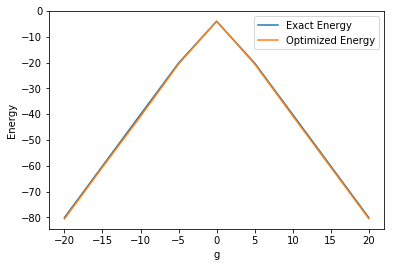

In [156]:
plt.plot(gs, exact, label='Exact Energy')
plt.plot(gs, energy, label='Optimized Energy')
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

Text(0,0.5,'Parameter')

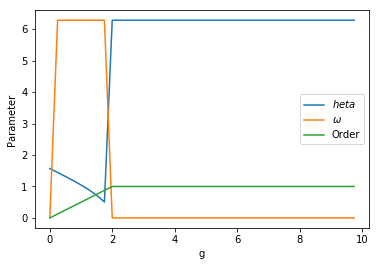

In [169]:
def wrap_angle(x):
    x = x % (2*pi)
    return x

def order(size, theta):
    return sum(sum(np.exp(1j*(theta[0] + theta[1]*(i+j))) for j in range(size[1])) for i in range(size[0])) / (size[0]*size[1])
    

plt.plot(gs, [wrap_angle(param[0]) for param in theta], label='$\theta$')
plt.plot(gs, [wrap_angle(param[1]) for param in theta], label='$\omega$')
plt.plot(gs, [order(size, param) for param in theta], label='Order')
plt.legend()
plt.xlabel('g')
plt.ylabel('Parameter')

Text(0,0.5,'Overlap')

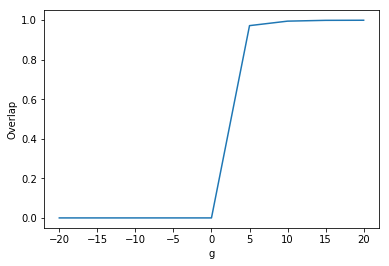

In [158]:
overlap = []

for i in range(len(gs)):
    h = [0,0,gs[i]]
    H = ising_hamiltonian(size, h, J, D)
    w, v = la.eig(make_Hamiltonian(H))
    circuit = ['c' + "ASDF"]    # unique random circuit for no collision
    Q_program.add_circuit(circuit[0], spin_wave_circuit(size, theta[i]))
    result = Q_program.execute(circuit, device, shots=1,
                                       config={"data": ["quantum_state"]})
    quantum_state = result.get_data(circuit[0]).get('quantum_state')
    overlap.append(np.abs(np.dot(v[:,0], quantum_state))**2)
    
plt.plot(gs, overlap)
plt.xlabel('g')
plt.ylabel('Overlap')

## Zooming In on (A)FM transition

In [159]:
#All of these need to be redefined so the program runs
def cost_function(Q_program, size, H, theta):
    shots = 1 #TODO: Should this ever change?
    return eval_hamiltonian(Q_program, H, spin_wave_circuit(size, theta), shots, device).real

def NM_optimize(size, H, theta_i, max_steps):
    options = {'disp' : True, 'maxiter': max_steps}
    cost = partial(cost_function, Q_program, size, H)
    res = optimize.minimize(cost, theta_i, method="Nelder-Mead", options=options)
    output = [res.fun, res.x]
    return output

def optim(size, H, theta_i, max_steps):
    return NM_optimize(size, H, theta_i, max_steps)

In [174]:
#Creating a program
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken,Qconfig.config["url"])

size = [6,1]

energy = []
theta = []
exact = []
overlap = []
gs = np.arange(0,5,0.25)
theta_g = (pi/2,pi)
seeds = 10
max_steps = 20
J = [-1,0,0]

for g in gs:
    h = [0,0,g]
    H = ising_hamiltonian(size, h, J, D)
    exact.append(np.amin(la.eig(make_Hamiltonian(H))[0]).real)
    H = make_Hamiltonian(H)
    res = (float('Inf'),)
    for seed in range(seeds):
        theta_i = npr.rand(2)*pi #We're only doing x/z terms, so no need for phi rotations
        results = optim(size, H, theta_i, max_steps)
        if results[0] < res[0]:
            res = results
    print(g, res, exact[-1])
    energy.append(res[0])
    theta.append(res[1])
    theta_g = res[1]

0.0 [-5.999829952947145, array([1.57119967, 3.1432394 ])] -6.000000000000002
0.25 [-6.007888233272832, array([1.51965086, 3.16390226])] -6.094180659279413
0.5 [-6.032047709120797, array([1.46297429, 3.18510299])] -6.384694563603681
0.75 [-6.071910275934151, array([1.41290108, 3.20519117])] -6.909787069091311
1.0 [-6.1272579659364705, array([1.35755379, 3.22583424])] -7.727406610312569
1.25 [-7.283907809188498, array([-0.33738136,  0.09487603])] -8.811005593761953
1.5 [-8.99974343879148, array([ 6.29151396e+00, -3.88820837e-03])] -10.056946423167547
1.75 [-10.499190375951263, array([-0.01525489,  0.00665256])] -11.389055552798785
2.0 [-6.911825722515901, array([4.89141502, 0.52654606])] -12.769389127207326
2.25 [-13.497346993673418, array([6.28235325e+00, 5.36179877e-03])] -14.179250129669597
2.5 [-14.999336057108938, array([-0.00233001, -0.00171703])] -15.60860910924971
2.75 [-16.499128798589634, array([ 0.0140593 , -0.00572405])] -17.051599656425715


3.0 [-17.994073530775083, array([-0.03412724,  0.01430877])] -18.5045401299555
3.25 [-19.154191108811943, array([6.18712534, 0.07848694])] -19.964989376710662
3.5 [-20.985359366623285, array([ 6.33103627, -0.00815723])] -21.4312573107297
3.75 [-22.495274296249043, array([6.25670442, 0.01146714])] -22.902132696069444
4.0 [-23.98121382360995, array([-0.05428496,  0.02235651])] -24.376722637117744
4.25 [-25.48891517945497, array([-0.04368867,  0.01665338])] -25.854353273072746
4.5 [-26.966111855106835, array([-0.04524863,  0.02549987])] -27.33450583698555
4.75 [-28.40342335044105, array([ 0.12472122, -0.04647807])] -28.81677408268336


Text(0,0.5,'Energy')

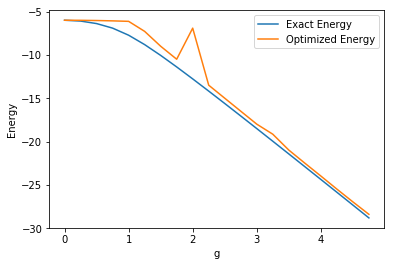

In [175]:
plt.plot(gs, exact, label='Exact Energy')
plt.plot(gs, energy, label='Optimized Energy')
plt.legend()
plt.xlabel('g')
plt.ylabel('Energy')

Text(0,0.5,'Parameter')

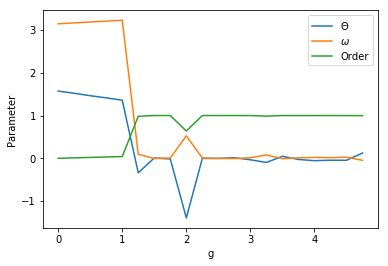

In [185]:
def wrap_angle(x):
    if x > 3*pi/2:
        x = x - 2*pi
    return x
plt.plot(gs, [wrap_angle(param[0]) for param in theta], label='$\Theta$')
plt.plot(gs, [wrap_angle(param[1]) for param in theta], label='$\omega$')
plt.plot(gs, [order(size, param) for param in theta], label='Order')
plt.legend()
plt.xlabel('g')
plt.ylabel('Parameter')

In [177]:
overlap = []

for i in range(len(gs)):
    h = [0,0,gs[i]]
    H = ising_hamiltonian(size, h, J, D)
    w, v = la.eig(make_Hamiltonian(H))
    circuit = ['c' + "ASDF"]    # unique random circuit for no collision
    Q_program.add_circuit(circuit[0], spin_wave_circuit(size, theta[i]))
    result = Q_program.execute(circuit, device, shots=1,
                                       config={"data": ["quantum_state"]})
    quantum_state = result.get_data(circuit[0]).get('quantum_state')
    overlap.append(np.abs(np.dot(v[:,0], quantum_state))**2)

Text(0,0.5,'Overlap')

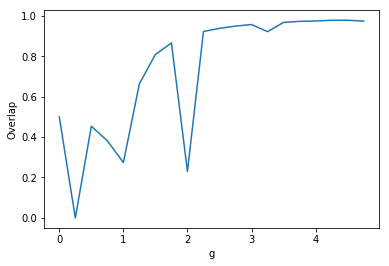

In [178]:
plt.plot(gs, overlap)
plt.xlabel('g')
plt.ylabel('Overlap')